This notebook has been adapted from [source](https://github.com/dair-ai/pytorch_notebooks)

## Emototion Detection

In [ ]:
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time

```json
@inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing"
    year = "2018",
    address = "Brussels, Belgium",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D18-1404",
    doi = "10.18653/v1/D18-1404",
    pages = "3687--3697"
}
```

In [ ]:
!gdown "1OB-GpME7CyFPHan9W_9Njtc2_PmvvKK7"

Downloading...
From: https://drive.google.com/uc?id=1OB-GpME7CyFPHan9W_9Njtc2_PmvvKK7
To: /content/emotion_detection_dataset.csv
100% 43.3M/43.3M [00:00<00:00, 87.2MB/s]


In [ ]:
import pandas as pd
data = pd.read_csv("emotion_detection_dataset.csv")
data

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
416804,that was what i felt when i was finally accept...,joy
416805,i take every day as it comes i m just focussin...,fear
416806,i just suddenly feel that everything was fake,sadness
416807,im feeling more eager than ever to claw back w...,joy


<Axes: xlabel='emotions'>

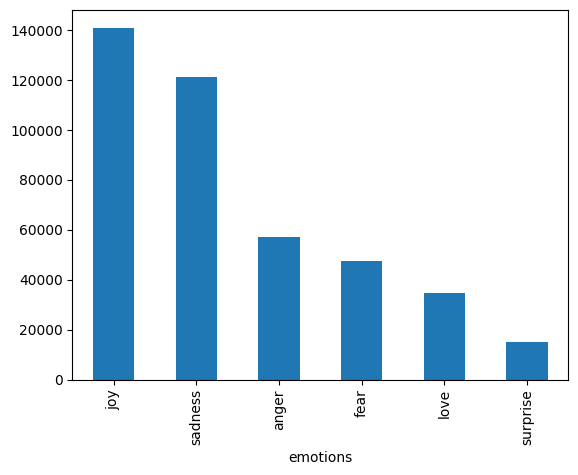

In [ ]:
data['emotions'].value_counts().plot(kind="bar")

## Tokenizing and Sampling
In the next steps we are going to **tokenize** our pieces of text, create index mapping for words, and also construct a vocabulary.

In [ ]:
## retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] =
data =

## sampling; we don't need to use the entire data as we only want to show you
## the tokenization/batch preparation process
data = data.sample(n=50000);

print(data.head(10))

                                                     text emotions  token_size
396372  i wanted to write something at least once a we...      joy          33
20731   i just feel that i should be more outgoing mee...      joy          14
415076                 i look at that bush and feel happy      joy           8
290129  i want to write about feeling like a miserable...  sadness          16
36      i am only having day a week where i am feeling...  sadness          15
65565   i think back i can see the giant sequoias the ...      joy          36
211495  i feel that i am just the reason why they are ...    anger          16
141299  im feeling nervous the original nord was so gr...     fear          19
25214   i feel really sad that im no more going to stu...  sadness          12
261280  i want to be feeling again and fucking faithfu...     love          20


### Building Vocabulary
After tokenizing text, it's time to build the vocabulary, which is used to determine the features that we will be using to train the models.

The code below takes create of creating the vocabulary. The code you see below is standard code you will see in many tutorials. Take some time to understand the intuition behind it.


In [ ]:
## This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa
## (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        # update with individual tokens

        # sort the vocab

        # add a padding token with index 0

        # word to index mapping

        # index to word mapping


In [ ]:
## construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

## examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaaaaaaaaaaaaaarrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrggggggggggggggggggggggggggggghhhhhhhhhhhhhh',
 'aaaaaaaall',
 'aaaaall',
 'aaaaand',
 'aac',
 'aahhing',
 'aakash']

In [ ]:
## obtain id of token
inputs.word2idx['a']

1

In [ ]:
## you can do the reverse now -- obtain the token via the id
inputs.idx2word[1]

'a'

### Converting Data Into Tensors
Now that we have created our vocab, we can now try to convert the text input into a tensor format, which inolves a vectorization processing using those vocab ids defined above.

Let's try:

In [ ]:
## vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
## examples of what is in the input tensors
input_tensor[0:2]

[[11547,
  26260,
  24454,
  26957,
  22256,
  1434,
  13641,
  16655,
  1,
  26423,
  16290,
  2062,
  11547,
  8706,
  24102,
  11547,
  10761,
  1046,
  17287,
  25791,
  24454,
  11723,
  24454,
  1041,
  7569,
  3232,
  2062,
  24210,
  12509,
  25932,
  24152,
  9201,
  14760],
 [11547,
  12969,
  8706,
  24102,
  11547,
  21517,
  2005,
  15462,
  16888,
  14828,
  17530,
  11806,
  15732,
  4205]]

### Padding Data
In order to train our recurrent neural network (RNN) model for text classification (prsented in the next notebook), we require some type of padding to generate inputs of same length. RNNs expect inputs of same lenght.

In [ ]:
## function to find max lenght of batch
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
## calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

67


In [ ]:
## padding sequences

import numpy as np

def pad_sequences(x, max_len):


In [ ]:
## inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

### Binarization
We would like to binarize our `target` values in our dataset so that we can obtain `one-hot encodings` for the target values.

In [ ]:
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

## convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

## binarizer


In [ ]:
## print the one-hot encodings for the first two examples in the dataset
target_tensor[0:2]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [ ]:
## we can easily check the original values for the first two piece of text
data[0:2]

,text,emotions,token_size
396372,i wanted to write something at least once a we...,joy,33
20731,i just feel that i should be more outgoing mee...,joy,14


In [ ]:
## we can easily find the emotion index for instance of the first example above: fear
get_emotion = lambda t: np.argmax(t)
get_emotion(target_tensor[0])

2

In [ ]:
## pass that index to a key/value object to obtain the original emotion
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
emotion_dict[get_emotion(target_tensor[0])]

'joy'

### Split Data

We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

Let's do that below. We are going to use the built in `train_test_split` dataset from scikit learn. Let's do that below:

In [ ]:
## Creating training and validation sets using an 80-20 split


## Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50


## Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

### Dataset and Data Loader

We can also load the data into a PyTorch `DataLoader` object, which makes it easy to manipulate the data, create batches, and apply further transformations. This simplified our training procedure as well -- we will look a this in the next notebook.

In [ ]:
## Define a few useful parameters

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [ ]:
from torch.utils.data import Dataset, DataLoader

We use the `Dataset` class to represent a dataset object. You override a few methods and you should be able to create the dataset object you need.

In [ ]:
class MyData(Dataset):
    def __init__(self, X, y):

    def __getitem__(self, index):

    def __len__(self):


Load the data and then pass it to an `iterator` called `DataLoadder` which finally defines how samples/batches should be prepared.

In [ ]:
## Dataset instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


## Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

In [ ]:
val_dataset.batch_size

64

In [ ]:
## preview of the data
val_dataset.dataset.data[0:2]

[array([11547, 10737,  8706, 15956,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]),
 array([11547,  6903, 23668,  8706, 25932,  7860,  3265, 15504,  2549,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

## RNN

Let's make a simple RNN model with 1 RNN layer and a fully connected layer. We will also need an embedding layer to embed the input sequence to a lower dimension and then a dropout layer to reduce overfitting.

In [ ]:
class EmoRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoRNN, self).__init__()

        ## layers

    def initialize_hidden_state(self):

    def forward(self, x, lens):


In [ ]:
# parameters
TRAIN_BUFFER_SIZE = 40000 # len(input_tensor_train)
VAL_BUFFER_SIZE = 5000 # len(input_tensor_val)
TEST_BUFFER_SIZE = 5000 # len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = 27291 # len(inputs.word2idx)
target_size = 6 # num_emotions

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Enabling cuda
model = EmoRNN(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    ## convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target)
    return loss

def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3057
Epoch 1 Batch 100 Val. Loss 0.2951
Epoch 1 Batch 200 Val. Loss 0.2858
Epoch 1 Batch 300 Val. Loss 0.2957
Epoch 1 Batch 400 Val. Loss 0.2821
Epoch 1 Batch 500 Val. Loss 0.2718
Epoch 1 Batch 600 Val. Loss 0.2432
Epoch 1 Loss 0.2789 -- Train Acc. 30.7050 -- Val Acc. 31.9511
Time taken for 1 epoch 10.714972972869873 sec

Epoch 2 Batch 0 Val. Loss 0.2515
Epoch 2 Batch 100 Val. Loss 0.2910
Epoch 2 Batch 200 Val. Loss 0.2567
Epoch 2 Batch 300 Val. Loss 0.2866
Epoch 2 Batch 400 Val. Loss 0.2810
Epoch 2 Batch 500 Val. Loss 0.2507
Epoch 2 Batch 600 Val. Loss 0.2780
Epoch 2 Loss 0.2757 -- Train Acc. 30.9125 -- Val Acc. 29.7276
Time taken for 1 epoch 10.481122255325317 sec

Epoch 3 Batch 0 Val. Loss 0.2811
Epoch 3 Batch 100 Val. Loss 0.2459
Epoch 3 Batch 200 Val. Loss 0.2844
Epoch 3 Batch 300 Val. Loss 0.2346
Epoch 3 Batch 400 Val. Loss 0.2750
Epoch 3 Batch 500 Val. Loss 0.2766
Epoch 3 Batch 600 Val. Loss 0.2462
Epoch 3 Loss 0.2754 -- Train Acc. 31.1525 -- Val Acc.

## GRU

We will just replace the RNN layer with GRU layer.

In [ ]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super().__init__()

        ## layers


    def initialize_hidden_state(self):


    def forward(self, x, lens):


In [ ]:
## Enabling cuda
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.2801
Epoch 1 Batch 100 Val. Loss 0.2839
Epoch 1 Batch 200 Val. Loss 0.2342
Epoch 1 Batch 300 Val. Loss 0.0912
Epoch 1 Batch 400 Val. Loss 0.0673
Epoch 1 Batch 500 Val. Loss 0.0185
Epoch 1 Batch 600 Val. Loss 0.0404
Epoch 1 Loss 0.1388 -- Train Acc. 68.0850 -- Val Acc. 90.9856
Time taken for 1 epoch 25.329009771347046 sec

Epoch 2 Batch 0 Val. Loss 0.0180
Epoch 2 Batch 100 Val. Loss 0.0355
Epoch 2 Batch 200 Val. Loss 0.0370
Epoch 2 Batch 300 Val. Loss 0.0250
Epoch 2 Batch 400 Val. Loss 0.0253
Epoch 2 Batch 500 Val. Loss 0.0133
Epoch 2 Batch 600 Val. Loss 0.0155
Epoch 2 Loss 0.0257 -- Train Acc. 93.0100 -- Val Acc. 92.8085
Time taken for 1 epoch 25.492727756500244 sec

Epoch 3 Batch 0 Val. Loss 0.0184
Epoch 3 Batch 100 Val. Loss 0.0163
Epoch 3 Batch 200 Val. Loss 0.0126
Epoch 3 Batch 300 Val. Loss 0.0262
Epoch 3 Batch 400 Val. Loss 0.0254
Epoch 3 Batch 500 Val. Loss 0.0258
Epoch 3 Batch 600 Val. Loss 0.0271
Epoch 3 Loss 0.0195 -- Train Acc. 94.3100 -- Val Acc.

## LSTM

Now, we will replace the RNN layer with LSTM layer. Remember LSTM also keeps a cell state so we need to add that too.

In [ ]:
class EmoLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):

        ## layers


    def initialize_hidden_state(self):
        return torch.zeros(1, self.batch_sz, self.hidden_units)

    def forward(self, x, lens):


In [ ]:
## Enabling cuda
model = EmoLSTM(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3059
Epoch 1 Batch 100 Val. Loss 0.2636
Epoch 1 Batch 200 Val. Loss 0.2870
Epoch 1 Batch 300 Val. Loss 0.2633
Epoch 1 Batch 400 Val. Loss 0.2499
Epoch 1 Batch 500 Val. Loss 0.2826
Epoch 1 Batch 600 Val. Loss 0.2550
Epoch 1 Loss 0.2639 -- Train Acc. 33.1100 -- Val Acc. 31.9111
Time taken for 1 epoch 32.11557602882385 sec

Epoch 2 Batch 0 Val. Loss 0.2686
Epoch 2 Batch 100 Val. Loss 0.2765
Epoch 2 Batch 200 Val. Loss 0.2518
Epoch 2 Batch 300 Val. Loss 0.2442
Epoch 2 Batch 400 Val. Loss 0.2606
Epoch 2 Batch 500 Val. Loss 0.2487
Epoch 2 Batch 600 Val. Loss 0.2749
Epoch 2 Loss 0.2631 -- Train Acc. 33.2225 -- Val Acc. 32.5721
Time taken for 1 epoch 31.935078620910645 sec

Epoch 3 Batch 0 Val. Loss 0.2538
Epoch 3 Batch 100 Val. Loss 0.2595
Epoch 3 Batch 200 Val. Loss 0.2522
Epoch 3 Batch 300 Val. Loss 0.2603
Epoch 3 Batch 400 Val. Loss 0.2626
Epoch 3 Batch 500 Val. Loss 0.2628
Epoch 3 Batch 600 Val. Loss 0.2531
Epoch 3 Loss 0.2630 -- Train Acc. 33.3050 -- Val Acc. 